Визуализация аугментированных данных

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
import librosa
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_parquet('/content/initial_data.parquet')

In [ ]:
signal = df['signal'][0]

In [ ]:
def add_awgn(signal, snr_db=20):
    noise = np.random.normal(0, 1, len(signal))
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.sqrt(noise_power) * noise
    return signal + noise

def bandpass_filter(signal, sr=50, lowcut=0.1, highcut=15.0, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)


def time_shift(signal, shift_max=0.1):
    shift = np.random.randint(-int(shift_max * len(signal)), int(shift_max * len(signal)))
    return np.roll(signal, shift)

def pitch_shift(signal, sr=50, pitch_range=0.1):
    steps = np.random.uniform(-pitch_range, pitch_range)
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=steps)


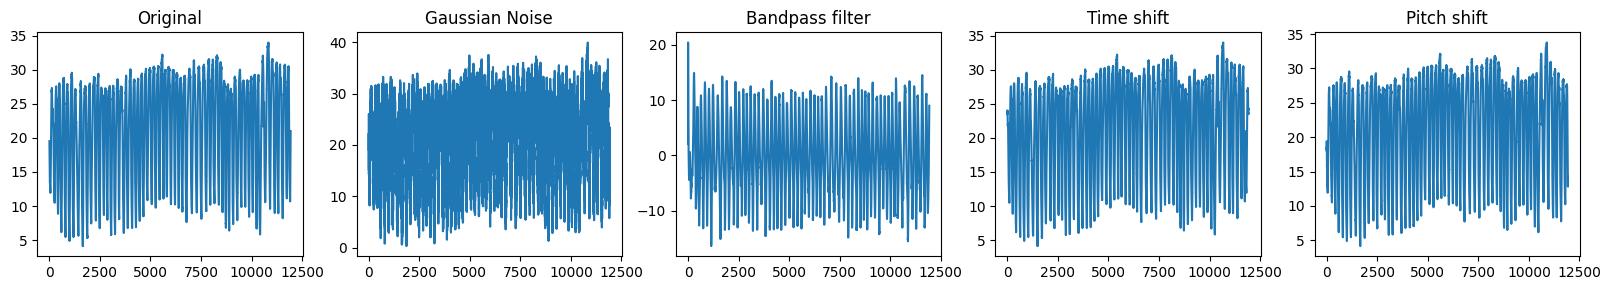

In [ ]:
plt.figure(figsize=(16, 3))
plt.subplot(1, 5, 1)
plt.plot(signal)
plt.title('Original')
plt.subplot(1, 5, 2)
plt.plot(add_awgn(signal))
plt.title('Gaussian Noise')
plt.subplot(1, 5, 3)
plt.plot(bandpass_filter(signal))
plt.title('Bandpass filter')
plt.subplot(1, 5, 4)
plt.plot(time_shift(signal))
plt.title('Time shift')
plt.subplot(1, 5, 5)
plt.plot(pitch_shift(signal))
plt.title('Pitch shift')
plt.tight_layout()

Визуализация признаков

In [ ]:
def extract_mfcc(signal, sr=50, n_mfcc=40):
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    return mfcc
def extract_chroma_stft(signal, sr=50):
    stft = np.abs(librosa.stft(signal, n_fft=64, hop_length=16))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr, tuning=0)
    return chroma
def extract_mel_spectrogram(signal, sr=50, n_mels=40):
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db
def extract_spectral_rolloff(signal, sr=50, roll_percent=0.85):
    S = np.abs(librosa.stft(signal, n_fft=1024))
    rolloff = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85)
    return rolloff[0]
def extract_zero_crossing_rate(signal):
    zcr = librosa.feature.zero_crossing_rate(signal-np.mean(signal), frame_length=100, hop_length=50)
    return zcr[0]

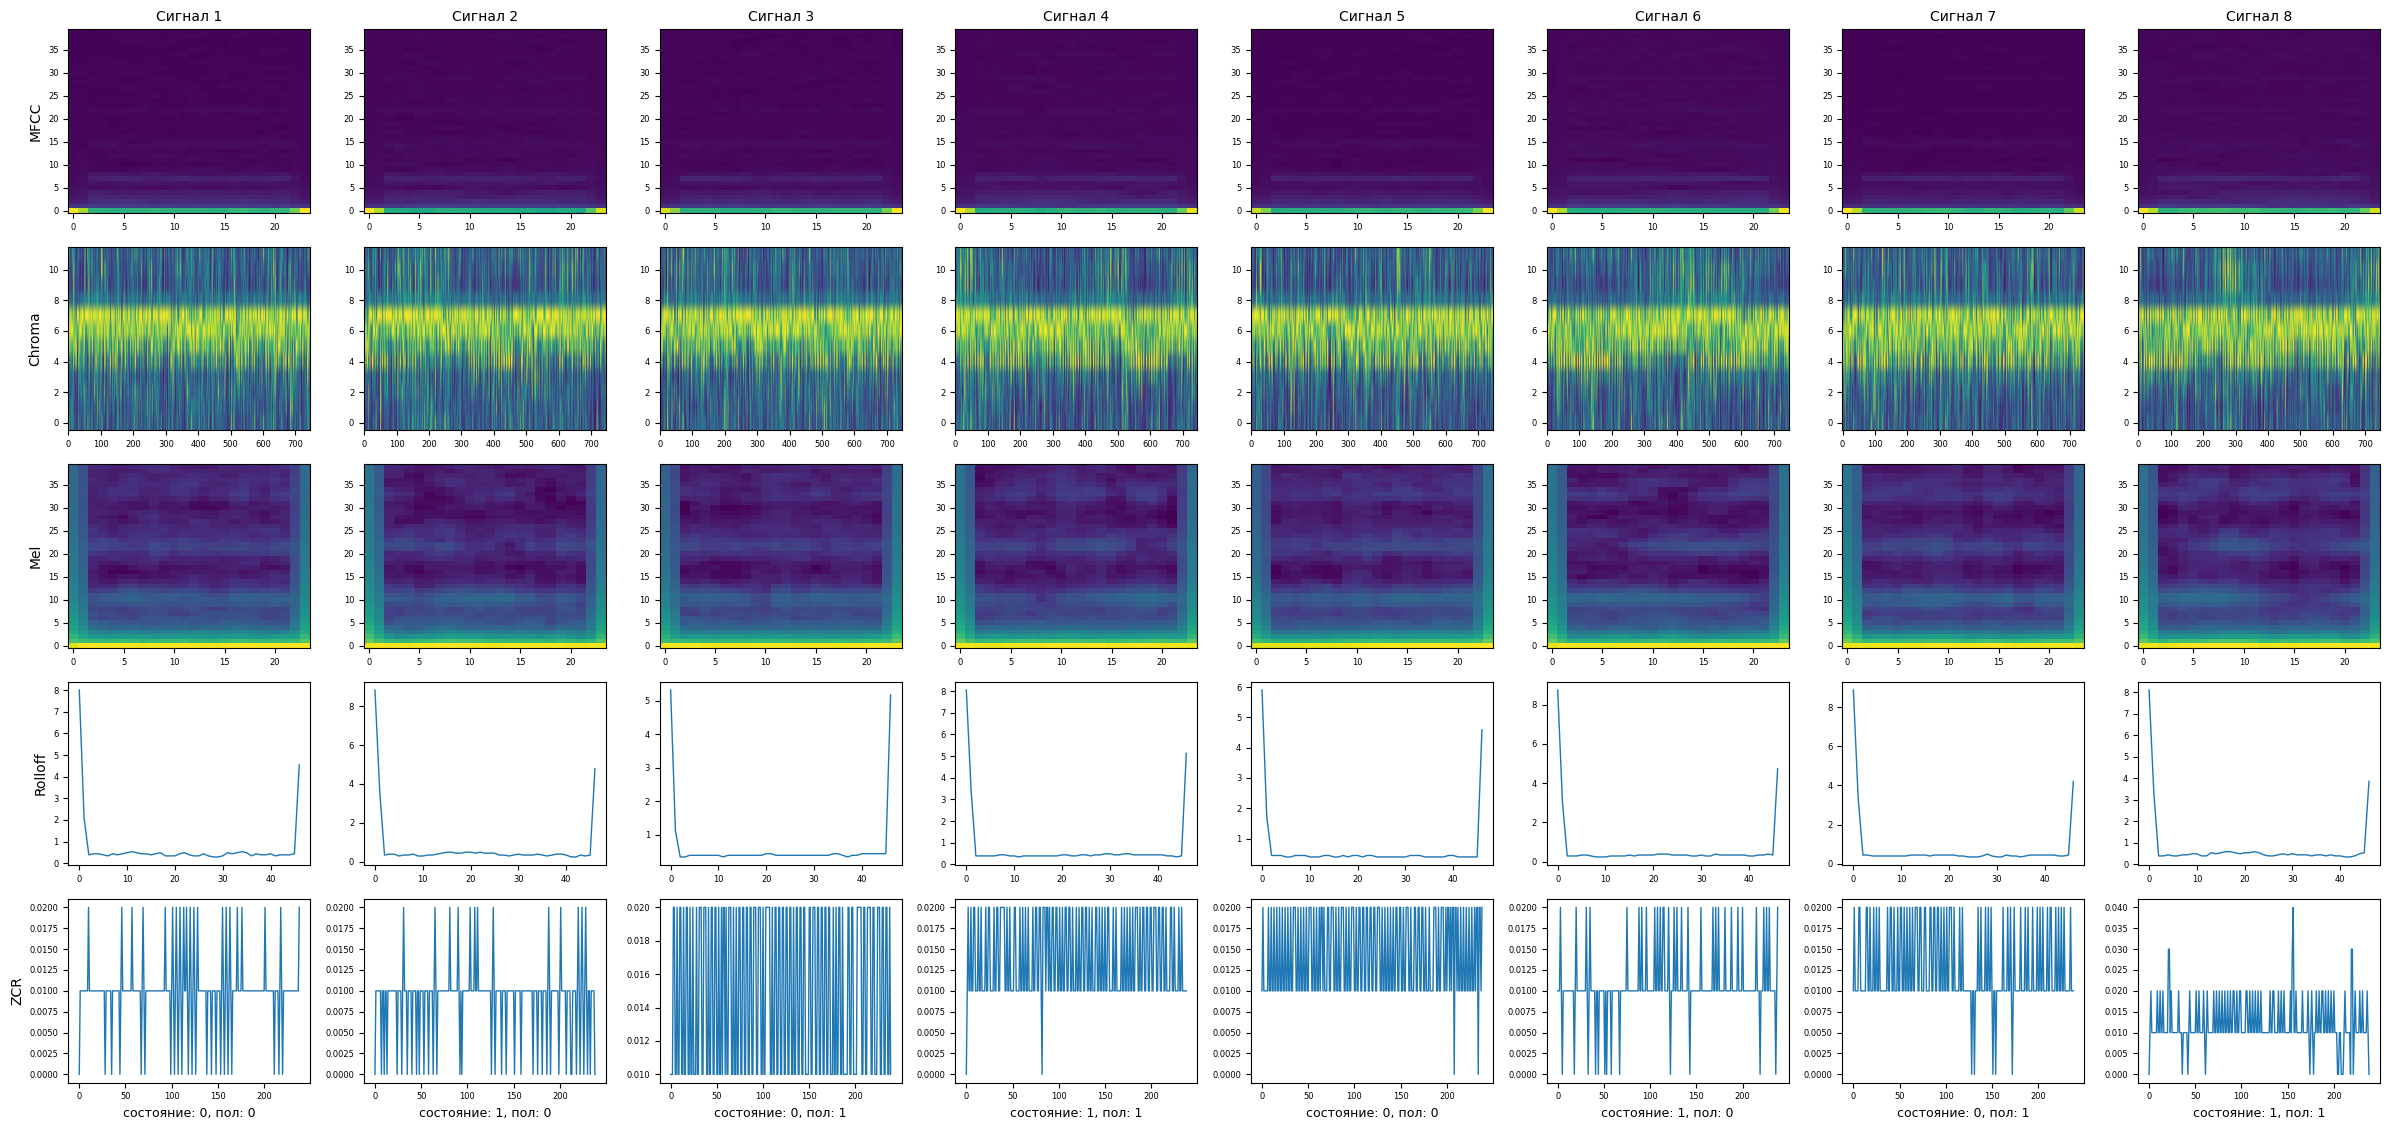

In [ ]:
fig, axes = plt.subplots(5, 8, figsize=(24, 12), sharex=False)


for i in range(8):
    signal = df['signal'][i]
    state = df['state'][i]
    gender = df['gender'][i]

    features = [
        extract_mfcc(signal),
        extract_chroma_stft(signal),
        extract_mel_spectrogram(signal),
        extract_spectral_rolloff(signal),
        extract_zero_crossing_rate(signal)
    ]

    for j, feat in enumerate(features):
        ax = axes[j, i]
        if feat.ndim == 2:
            im = ax.imshow(feat, aspect='auto', origin='lower', cmap='viridis')
        else:
            ax.plot(feat, linewidth=1)

        if i == 0:
            ax.set_ylabel(feature_names[j], fontsize=10)

        if j == 4:
            ax.set_xlabel(f'состояние: {state}, пол: {gender}', fontsize=9)

        ax.tick_params(labelsize=6)

for i in range(8):
    axes[0, i].set_title(f'Сигнал {i+1}', fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
